# Explaining by Removing: a thorough investigation of feature attributions
*Assignment created by **Jaap Jumelet**, with additional help from **Tom Kersten** and **Jelle Zuidema**. Part of the UvA AI MSc course Interpretability & Explainability in AI, June 2022.*

### Introduction
In this assignment you will gain a better understanding of Feature Attribution methods. Feature Attribution methods explain the prediction of a model as a sum of contributions from the input features. For example, if we were to be explaining the output of a language model (that assigns a probability to the next token) on the input "*The athletes above Barbara ...", the output of "*walk*" could be explained as the following sum of contributions:

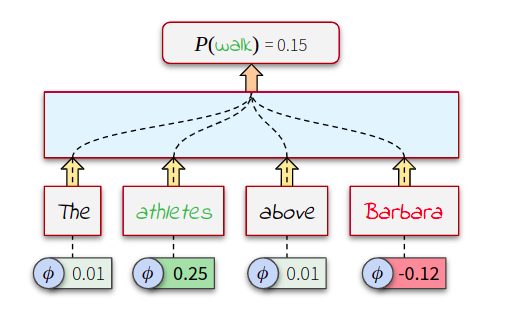

A lot of attribution methods have been proposed over the passed few years. You may have heard of some of them, like LIME, SHAP, Integrated Gradients, or GradCAM. Each of these methods have their own strengths and weaknesses, but has become increasingly harder to make sense of which method is truly the most **faithful** to the actual behaviour of the underlying model. This is a notoriously hard problem, because we don't have access to the "*gold explanation*" of model behaviour: it is, after all, precisely this gold explanation that we are trying to obtain via our feature attribution methods.

In an effort to make more sense of the landscape of attribution methods, [Covert et al. (2021)](https://arxiv.org/pdf/2011.14878.pdf) devised three dimensions that characterise a method:

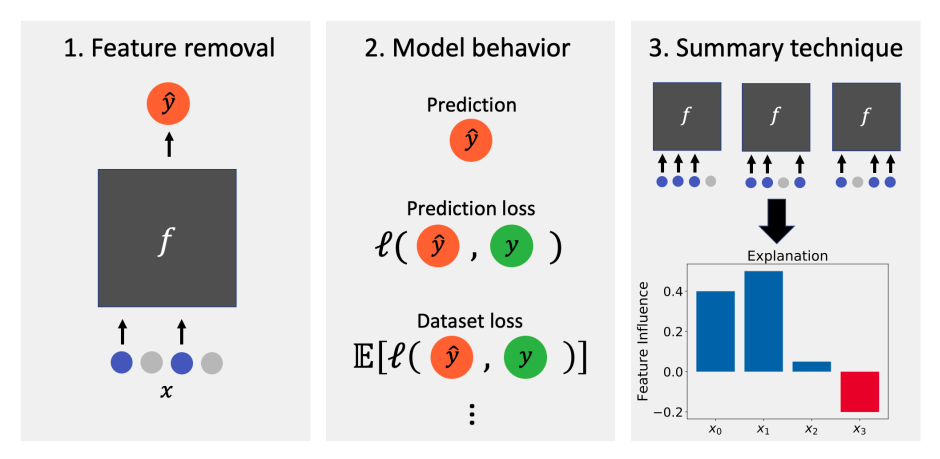

1. The first, feature removal, defines how we deal with removing (subsets of) features from an input. This is often done to create explanations: the behaviour of a model is compared on what happens if we modify parts of our input. Humans generate explanations like this often as well: we explain our behaviour by comparing it to what we could have done instead.

2. The second, model behaviour, is less useful for us, as we will solely be focusing on explaining model *predictions*, and not care about the model loss.

3. The third, summary technique, ties in to the first dimension in how we aggregate the model outputs on the modified inputs that we obtained with our feature removal procedure. At this point you are probably familiar with the Shapley value, this is a specific instance of a summary technique.

These three dimensions lead to the following table that sketches part of the attribution landscape:

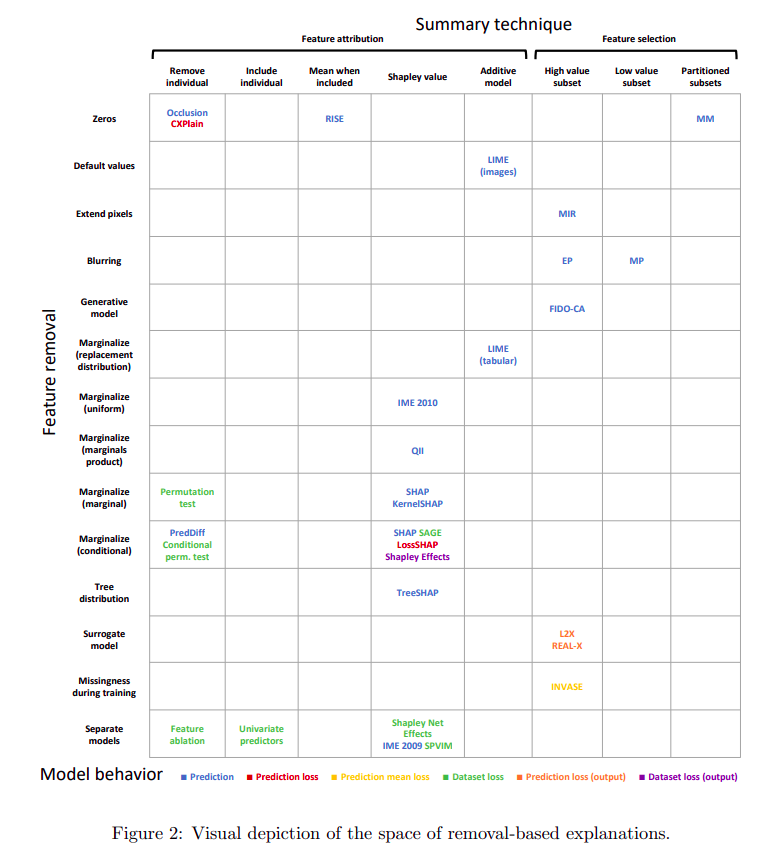

## Assignment
In our assignment we will focus on a small subset of attribution methods, and compare these. We will look into methods that aim to evaluate and quantify the faithfulness of an attribution method. You will use these methods to conduct a small-scale qualitative analysis on a **sentiment classification** model. After all, attribution methods should provide us a better insight into the reasoning of a model, so ideally an attribution will give us a better, more qualitative insight into its behaviour.

## Models and Data

For your experiments, you will make use of the RoBERTa model ([Liu et al. 2019 ](https://arxiv.org/abs/1907.11692)). RoBERTa, as you may recall, is an extension of BERT for which the pretraining procedure has been changed. Importantly, RoBERTa has been trained on more data, with longer sequences. However, it removed the next sentence prediction objective.

We will evaluate our model using the Stanford Sentiment Treebank (or [SST2](https://arxiv.org/abs/1804.07461)) dataset. The dataset consists out of 11,855 movie reviews, each annotated with sentiment. This kind of data is ideal for attribution extraction, as sentiment often contains very clear words which mark the sentiment for that sentence.

**N.B.: Before you run this cell make sure GPU support is enabled! Some of the methods we will be using are quite compute-heavy.**

In [ ]:
!pip install transformers datasets captum

import transformers
import torch
import os
import numpy as np
import pandas as pd
from typing import *
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def load_model(path):
    tokenizer = AutoTokenizer.from_pretrained(path)
    model = AutoModelForSequenceClassification.from_pretrained(path)
    model.eval()
    model.to(DEVICE)

    return model, tokenizer


# We use a fine-tuned roberta model in our experiments
model, tokenizer = load_model("textattack/roberta-base-SST-2")

# Append a zero-valued embedding that will be used as a baseline later on
orig_embs = model.roberta.embeddings.word_embeddings.weight.data
new_embs = torch.cat((orig_embs, torch.zeros(1, orig_embs.shape[-1]).to(DEVICE)))
model.roberta.embeddings.word_embeddings.weight.data = new_embs
model.roberta.embeddings.word_embeddings.num_embeddings += 1

zero_id = torch.tensor(50265).to(DEVICE)

Some weights of the model checkpoint at textattack/roberta-base-SST-2 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


For the sentiment classification task we will make use of Huggingface's `datasets` library, which makes it very easy to load in SST2 and do post-processing on it.

In [ ]:
from datasets import load_dataset


# We can directly load in the SST2 dataset
dataset = load_dataset("gpt3mix/sst2")


# We still need to encode the raw sentences based on the tokenizer we're using
def encode(batch):
    encoded = tokenizer(
        batch["text"],
        padding="longest",
        truncation=True,
        max_length=512,
        return_tensors="pt",
    ).to(DEVICE)

    # Invert labels (0 <> 1), because it's the other way around somehow for roberta
    batch['label'] = (~torch.tensor(batch['label']).bool()).long()
    batch['text'] = [
        tokenizer.tokenize(sen, add_special_tokens=True)
        for sen in batch['text']
    ]

    return {**encoded, **batch}


dataset.set_transform(encode)

  0%|          | 0/3 [00:00<?, ?it/s]

<font color='green'><b>ToDo 1</b></font>

Inspect the data you have been given. Make sure you understand what the data looks like, and what the labels mean. Try to iterate over your data, and see what happens if you try to access a single item in the corpus, or multiple at once.

In [ ]:
for attr, value in dataset['train'][:2].items():
    print(f"{attr:<15}", value)

input_ids       tensor([[    0,   133,  2751,    16, 19083,     7,    28,     5,   733,   620,
          9348,   128,    29,    92, 45518, 38650, 12801,     8,    14,    37,
           128,    29,   164,     7,   146,    10, 17158,   190,  2388,    87,
         11816, 28797,  2156,  5363,    12, 11428,  5247,  3415,  8234,  1794,
            50,  5031,  1608,  9487,   479,     2,     1,     1,     1,     1,
             1,     1,     1],
        [    0,   133, 39966,  9412, 10986, 18719,     9, 45518,    20,  5736,
             9,     5, 32106, 12801, 26105,    16,    98,  1307,    14,    10,
          6730,     9,  1617,    64,    45, 17327,  6190,  1029,    12,  9408,
         48182, 19709,  2155,  2250,   128,    29,  4939,  3360,     9,   344,
             4,   500,     4,   500,     4, 44107,   128,    29,  2367,    12,
         25581,   479,     2]], device='cuda:0')
attention_mask  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1,

Now that you have inspected the data, let us try to use it alongside the loaded model.

<font color='green'><b>ToDo 2</b></font>

*   Produce a prediction using the model for the first sentence in the dataset in the test set.
*   List 5 sentences from the test set for which the model produces **incorrect** predictions (in the test set).

<font color='red'><b>ToSubmit 1</b></font>
The list of 5 sentences you have found on which the model makes an incorrect prediction. Add a brief caption to the listing in which you state some patterns that you observe (max 50 words).

In [ ]:
# Your code here (producing a single prediction)
input_text = dataset['test'][:1]['input_ids']
logits = model(input_text).logits
predicted_class_id = logits.argmax().item()
print(predicted_class_id)

1


In [ ]:
# Your code here (list 5 sentences with incorrect predictions)
for i in range(1,150):
  # for attr, value in dataset['test'][:i].items():
  input_text = dataset['test'][i-1:i]['input_ids']
  logits = model(input_text).logits
  predicted_class_id = logits.argmax().item()
  if predicted_class_id != dataset['test'][i-1:i]['label']:
    print(dataset['test'][i-1:i]['text'])
    # print(dataset['test'][i-1:i]['attention_mask'])
    print("Predicted - ",predicted_class_id)
    print("Actual - ", dataset['test'][i-1:i]['label'][0])


[['<s>', 'Perhaps', 'Ġno', 'Ġpicture', 'Ġever', 'Ġmade', 'Ġhas', 'Ġmore', 'Ġliterally', 'Ġshowed', 'Ġthat', 'Ġthe', 'Ġroad', 'Ġto', 'Ġhell', 'Ġis', 'Ġpaved', 'Ġwith', 'Ġgood', 'Ġintentions', 'Ġ.', '</s>']]
Predicted -  0
Actual -  tensor(1)
[['<s>', 'If', 'Ġthere', "Ġ'", 's', 'Ġa', 'Ġway', 'Ġto', 'Ġeffectively', 'Ġteach', 'Ġkids', 'Ġabout', 'Ġthe', 'Ġdangers', 'Ġof', 'Ġdrugs', 'Ġ,', 'ĠI', 'Ġthink', 'Ġit', "Ġ'", 's', 'Ġin', 'Ġprojects', 'Ġlike', 'Ġthe', 'Ġ-', 'L', 'RB', '-', 'Ġunfortunately', 'ĠR', '-', 'rated', 'Ġ-', 'RR', 'B', '-', 'ĠPaid', 'Ġ.', '</s>']]
Predicted -  0
Actual -  tensor(1)
[['<s>', 'Son', 'Ġof', 'Ġthe', 'ĠBride', 'Ġmay', 'Ġbe', 'Ġa', 'Ġgood', 'Ġhalf', '-', 'hour', 'Ġtoo', 'Ġlong', 'Ġbut', 'Ġcomes', 'Ġrep', 'lete', 'Ġwith', 'Ġa', 'Ġflattering', 'Ġsense', 'Ġof', 'Ġmystery', 'Ġand', 'Ġquiet', 'ness', 'Ġ.', '</s>']]
Predicted -  1
Actual -  tensor(0)
[['<s>', '4', 'Ġfriends', 'Ġ,', 'Ġ2', 'Ġcouples', 'Ġ,', 'Ġ2000', 'Ġmiles', 'Ġ,', 'Ġand', 'Ġall', 'Ġthe', 'ĠP', 'ab', 'st', 

## Attribution Methods

For this workshop, you will look at several existing attribution methods, see how they work and compare and contrast their similarities and differences. For your experiments, you will consider the following attribution methods:

* Feature Ablation
* Shapley Values
* Integrated Gradients
* KernelShap

To make sure these four methods are compatible with subsequent evaluation procedures, we will let each instantiation inherit from an abstract `FeatureAttributor` class. Note that this class also contains a method to retrieve the model logits, which may be of use in your implementation of the attribution methods.

You can use the `visualize_attribution` method to visualize the attributions for a particular method.

In [ ]:
from abc import abstractmethod

from captum.attr import visualization
from IPython.display import display, HTML


class FeatureAttributor:
    def __init__(self, model):
        self.model = model

    @abstractmethod
    def attribute(
        self,
        input_ids: torch.Tensor,
        baseline_ids: torch.Tensor,
        target: int,
        **kwargs
    ) -> torch.Tensor:
        """
        Computes the attributions for a single input.

        Parameters
        ----------
        input_ids : torch.Tensor
            shape: (batch_size, sen_len)
        baseline_ids : torch.Tensor
            shape: (batch_size, sen_len)
        target : int
            Output class that is being explained

        Returns
        -------
        attributions : torch.Tensor
            shape: (sen_len,)
        """
        pass

    def logits(self, input_ids, target=None):
        squeeze_output = input_ids.ndim == 1
        if squeeze_output:
            input_ids = input_ids.unsqueeze(0)

        with torch.no_grad():
            logits = self.model(input_ids).logits[:, target]

        if squeeze_output:
            logits = logits.squeeze()

        return logits


def visualize_attribution(sen: List[str], attributions: torch.Tensor, normalize: bool = True):
    attributions = attributions.squeeze()

    if normalize:
        attributions /= torch.max(attributions.abs())

    raw_html = visualization.format_word_importances(
        sen, attributions
    )
    html = HTML(raw_html)
    display(html)

### Feature Ablation

Feature Ablation ([Li, Monroe and Jurafsky, 2016](https://arxiv.org/abs/1612.08220)) is a simple attribution method. We replace individiual tokens in the sentence with some baseline token, and measure the difference in output between the original sentence and the modified one. We then assign the resulting difference to the replaced token. This procedure is summarised in the following formula, where $a_{i}$ is the attribution score for the token at position $i$, $\mathcal{M}$ is the model and $\mathcal{F}_{i}$ is the replacement method at position $i$.

$$a_{i}(x) = \mathcal{M}(x) - \mathcal{M}(\mathcal{F}_i(x))$$

<font color='blue'><b>ToThink 1</b></font> Consider how we may model the exclusion of one or multiple tokens from our input. Do you completely remove the feature? Replace it with a default token? Or sample it from a distribution? What impact do these choices have on your explanations?

<font color='green'><b>ToDo 3</b></font>
Implement the ablation attribution method below. You can test your method on the example sentence that has been provided.

In [ ]:
class AblationAttributor(FeatureAttributor):
    def attribute(
        self,
        input_ids: torch.Tensor,
        baseline_ids: torch.Tensor,
        target: int,
    ) -> torch.Tensor:
        attributions = torch.zeros_like(input_ids, dtype=torch.float32)
        input_ids_len = input_ids.size(0)
        for i in range(len(input_ids)):
            input_ids_ablated = input_ids.clone()
            input_ids_ablated[i] = baseline_ids[i]
            attributions[i] = self.logits(input_ids_ablated, target) - self.logits(input_ids, target)
        return attributions

sen = "I wish I liked it more, although I did not dislike it"
item = {
    "input_ids": tokenizer(sen, return_tensors='pt').to(DEVICE)['input_ids'].squeeze(),
    "text": tokenizer.tokenize(sen, add_special_tokens=True),
    "label": torch.tensor(1),
}
input_ids = item['input_ids']
sen_len = len(item['text'])

# baseline_id = tokenizer.unk_token_id  # Set the baseline to the <unk> token
# baseline_id = tokenizer.pad_token_id
baseline_id = 0
baseline_ids = torch.tensor([baseline_id] * sen_len, device=DEVICE)
label = item['label'].item()

ablation_attributor = AblationAttributor(model)
ablation_attributions = ablation_attributor.attribute(input_ids, baseline_ids, label)

for w, phi in zip(item['text'], ablation_attributions):
    print(f"{w:<15} {phi.item():.3f}")

visualize_attribution(item['text'], ablation_attributions)
print(ablation_attributor.logits(input_ids))

<s>             0.000
I               0.738
Ġwish           2.318
ĠI              0.276
Ġliked          -0.280
Ġit             -0.408
Ġmore           0.452
,               -0.313
Ġalthough       -0.656
ĠI              -0.122
Ġdid            0.331
Ġnot            -2.329
Ġdislike        -1.249
Ġit             -0.029
</s>            -0.445


tensor([ 0.1251, -0.1425], device='cuda:0')


### Shapley Values

Another approach to assigning attribution scores comes from game theory. Shapley values ([Shapley, 1951](https://www.rand.org/pubs/research_memoranda/RM0670.html)) provide a framework for the assignment of contributions to players in a team. More specifically, we can estimate the contributions of a player by comparing the results of all coalitions including our player to those same coalitions without our player. These differences indicate the contributions of our player towards the game, and can be considered their attribution. The mathematical formulation for this procedure is as follows:

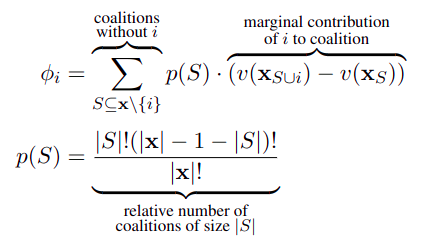

We can translate this concept to NLP by considering the team to be the input to the model. As such the players in our imaginary game have become the tokens in the input. We can evaluate the performance by looking at all possible coalitions (i.e. subsets) of our input with respect to a single token, either including or excluding it.

<font color='blue'><b>ToThink 2</b></font> How does the computation of a Shapley values scale, in terms of the number of input features?

<font color='green'><b>ToDo 4</b></font>
Fill in the missing part in `ShapleyAttributor.attribute` below. The model outputs have been pre-computed (`coalition_logits`), so all that is left to do is to finish the Shapley computation steps as outlined in the mathematical formulation above.

In [ ]:
from itertools import chain, combinations
from math import factorial
from tqdm import *


def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))


def coalitions_without_i(sen_len, i):
    features_not_i = [j for j in range(sen_len) if j != i]
    for coalition in powerset(features_not_i):
        yield coalition


class ShapleyAttributor(FeatureAttributor):
    def attribute(
        self,
        input_ids: torch.Tensor,
        baseline_ids: torch.Tensor,
        target: int,
    ) -> torch.Tensor:
        sen_len = input_ids.shape[-1]

        coalition_logits, coalition_to_index = self.compute_coalition_logits(
            input_ids, baseline_ids, target
        )

        shapley_values = torch.zeros(sen_len)

        for i in range(sen_len):
            for S in coalitions_without_i(sen_len, i):
                S_i = tuple(sorted(S + (i,)))
                index_S = coalition_to_index[S]
                index_S_i = coalition_to_index[S_i]

                # Your code for computing the Shapley value
                # Note you can use the index_S(_i) values to index the coalition_logits
                shapley_contribution = coalition_logits[index_S_i] - coalition_logits[index_S]
                shapley_values[i] += shapley_contribution / factorial(sen_len - 1)

        return shapley_values

    def compute_coalition_logits(self, input_ids, baseline_ids, target):
        """
        Computes the model output for all possible coalitions, in batches.

        Returns
        -------
        coalition_logits : torch.Tensor
            shape: (2**sen_len,)
            The output logit for each coalition
        coalition_to_index : Dict[Tuple[int], int]
            Dictionary mapping a coalition tuple to its index in the
            coalition_logits tensor.
        """
        sen_len = input_ids.shape[-1]
        num_coalitions = 2**sen_len

        coalitions = torch.zeros(num_coalitions, sen_len, dtype=torch.long).to(DEVICE)
        coalitions += baseline_ids  # set baseline as default

        coalition_to_index = {}

        for idx, coalition in enumerate(powerset(range(sen_len))):
            coalition_to_index[coalition] = idx
            if len(coalition) > 0:
                coalition = list(coalition)
                coalitions[idx, coalition] = input_ids[coalition]

        coalition_logits = torch.zeros(num_coalitions)
        batch_size = 1024
        batch_iterator = torch.split(coalitions, batch_size)
        for batch_idx, batch in tqdm_notebook(
            enumerate(batch_iterator), total=len(batch_iterator)
        ):
            with torch.no_grad():
                batch_logits = self.logits(batch, label)
            coalition_logits[
                batch_idx * batch_size : (batch_idx + 1) * batch_size
            ] = batch_logits

        return coalition_logits, coalition_to_index


shapley_attributor = ShapleyAttributor(model)
shapley_attributions = shapley_attributor.attribute(input_ids, baseline_id, label)

visualize_attribution(item["text"], shapley_attributions)


<ipython-input-156-8f35199257b3>:75: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, batch in tqdm_notebook(


  0%|          | 0/32 [00:00<?, ?it/s]

One of the main reasons to be using Shapley values as an explanation tool is that it is the unique method to satisfy various attractive "*axioms*", i.e. theoretical properties that are guaranteed to be true. One of these is **completeness**, which states that all attributions must sum up to the model's output on the input, minus the model's output on the baseline:

$$\sum_i\phi_i = f(x) - f(x')$$

The difference between the sum of attributions and model output is often referred to as the convergence $\delta$.

<font color='green'><b>ToDo 5</b></font>
Fill in the method for computing the compleness in the method defined below. Is the $\delta$ close to zero? Due to numerical instabilities it may be possible that it is not exactly 0.

In [ ]:
def completeness(attributor, input_ids, baseline_ids, target, **kwargs):
    attributions = attributor.attribute(input_ids, baseline_ids, target, **kwargs)
    attributions_clone = attributions.clone()

    perturbed_attributions = attributor.attribute(input_ids, input_ids, target, **kwargs)
    perturbed_attributions_clone = perturbed_attributions.clone()

    delta = torch.norm(attributions_clone - perturbed_attributions_clone)
    print(f"Delta: {delta.item()}")

    return delta


completeness(shapley_attributor, input_ids, baseline_ids, label)

<ipython-input-156-8f35199257b3>:75: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, batch in tqdm_notebook(


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Delta: 3.65324524409516e-07


tensor(3.6532e-07)

### KernelSHAP

Directly computing Shapley values is an expensive process, as it scales exponentially with the size of the input. Because of this, computing Shapley values for larger inputs becomes infeasible, especially over larger datasets. As such, approximations are needed to compute these values.

KernelSHAP ([Lundberg and Lee, 2017](https://arxiv.org/abs/1705.07874)) is one such approximation. It seeks to reduce the complexity to a managable scale by using a different approach called LIME ([Ribeiro, Singh, and Guestrin, 2016](https://arxiv.org/abs/1602.04938)). LIME seeks to produce a linear approximation of a model, and inspect this surrogate model. It trains a linear model on a simplified input, noting the presence or absence of individual training features, which produces a model which is able to mimic the original model. However, for this process a loss function, weighing kernel and a regularization term are needed. In Lunderberg and Lee (2017), they show that by carefully choosing these parameters, the regression coefficients of the model resemble the Shapley values corresponding to these.

<font color='green'><b>ToDo 6</b></font>
Fill in the missing part in `ShapAttributor.attribute` below. You can make use of the `captum` implementation of KernelSHAP (check out the API [here](https://captum.ai/api/kernel_shap.html)).

<font color='blue'><b>ToThink 3</b></font> Does KernelSHAP satisfy the completeness axiom?

In [ ]:
from captum.attr import KernelShap
from functools import partial

#def init_model_forward(model):
def model_forward_1(input_ids, model):
    return model(input_ids).logits
   # return model_forward


class ShapAttributor(FeatureAttributor):
    def attribute(
        self,
        input_ids: torch.Tensor,
        baseline_ids: torch.Tensor,
        target: int,
    ) -> torch.Tensor:
        ks = KernelShap(partial(model_forward_1, model = self.model))
        attr = ks.attribute(inputs = input_ids.unsqueeze(dim=0),
                            baselines = baseline_ids.unsqueeze(dim=0),
                            target = target)
        return attr.squeeze()



shap_attributor = ShapAttributor(model)
shap_attributions = shap_attributor.attribute(input_ids, baseline_ids, label)
visualize_attribution(item['text'], shap_attributions)

### Integrated Gradients

Integrated Gradients ([Sundararajan, Taly, and Yan, 2017](https://arxiv.org/abs/1703.01365)) seeks to assign attributions through measuring differences in output of a model as the input space changes. More specifically, we are looking to measure gradients along the path from some baseline input to our original input. In this way, Integrated Gradients performs Saliency Mapping at multiple points along the straightline path from a baseline input $x^\prime$ to the original input $x$. This operation is mathematically defined as:

$$ a_{i}(x)=\left(x_{i}-x_{i}^{\prime}\right) \times \int_{\alpha=0}^{1} \frac{\partial F\left(x^{\prime}+\alpha \times\left(x-x^{\prime}\right)\right)}{\partial x_{i}} d \alpha$$

As you can read in the original paper of IG, this path integral actually approximates a quantity from game theory as well, the Aumann-Shapley value, which can roughly be understood as the extension of the (discrete) Shapley value to the case in which the players are continuous. Fairly vague and hard to wrap your head around, so don't worry to much about it 😃.

<font color='green'><b>ToDo 7</b></font>
Fill in the missing part in `IGAttributor.attribute` below. You can make use of the `captum` implementation of Integrated Gradients. Make sure to have a look at the documentation of their implementation here: https://captum.ai/api/integrated_gradients.html

Important to keep in mind is that Integrated Gradients operate on the embedding space, and as such the method expects the input to be the word embeddings, and not the input ids. You can access the word embeddings of RoBERTa as follows: `model.roberta.embeddings.word_embeddings(..)`

<font color='blue'><b>ToThink 4</b></font> Does Integrated Gradients satisfy the completeness axiom? Does the convergence $\delta$ depend on the number of interpolation steps that are used to approximate the path integral?

In [ ]:
from captum.attr import IntegratedGradients


def model_forward(inputs_embeds, model):
    return model(inputs_embeds=inputs_embeds).logits


class IGAttributor(FeatureAttributor):
    def attribute(
        self,
        input_ids: torch.Tensor,
        baseline_ids: torch.Tensor,
        target: int,
        n_steps: int = 50,
    ) -> torch.Tensor:
        inputs_embeds = self.model.roberta.embeddings.word_embeddings(input_ids)
        baseline_embeddings = self.model.roberta.embeddings.word_embeddings(baseline_ids)

        # Create Integrated Gradients instance
        ig = IntegratedGradients(partial(model_forward, model = self.model))

        # Compute attributions using Integrated Gradients
        attributions, _ = ig.attribute(
            inputs=inputs_embeds.unsqueeze(dim=0),
            baselines=baseline_embeddings.unsqueeze(dim=0),
            target=target,
            n_steps=n_steps,
            return_convergence_delta=True,
        )
        attributions = attributions.sum(dim=-1)
        return attributions.squeeze()


ig_attributor = IGAttributor(model)
ig_attributions = ig_attributor.attribute(input_ids, baseline_ids, label)

visualize_attribution(item['text'], ig_attributions)

## Baselines
<font color='green'><b>ToDo 7.1</b></font>
In the previous cells we have been using an `<unk>` token as a baseline. How do the attributions change if you use a different fixed token instead? You could check another neutral token, like `<pad>`, a zero-valued baseline, or something else you think of yourself.

## Evaluation

Evaluating attribution methods is still a topic of debate in the scientific community. Several methods exsist which look at different aspects of these methods to gauge how well they explain the behaviour of the model. For this workshop, we will focus on three such methods:

- Comprehensiveness
- Sufficiency
- Area

### Comprehensiveness
Comprehensiveness ([DeYoung et al., 2020](https://aclanthology.org/2020.acl-main.408/)) is the average difference of the change in predicated class probability before and after removing the top k% of tokens according to the used attribution method. In doing so, we shorten the original sentence by removing the designated tokens. It is expected that by removing the top tokens, the predicated class probability will lower as important information for the prediction of the model should be captured in the top tokens. It is defined as:

$$\operatorname{Comp}(k)=\frac{1}{N} \sum_{i=1}^{N} p(y^* \mid \boldsymbol{x}_{i}) - p(y^* \mid \boldsymbol{x}_{i}^{(k)}),$$

where $N$ is the number of input sentences, ${y^*}$ the target class, $x_i$ the $i$-th input sentence and $x_{i}^{(k)}$ the modified sentence with the top k% tokens removed.

### Sufficiency
Sufficiency ([DeYoung et al, 2020](https://aclanthology.org/2020.acl-main.408/)) is the average difference of the change in predicated class probability before and after keeping only the top k% of tokens according to the used attribution method. This method is very similar to Comprehensiveness, but flips the premise and seeks to identify how much information is captured in only the top k% of tokens. This score is defined similarly to Comprehensiveness, only changing $x_{i}^{(k)}$ to mean the modififed sentence with only the top k% tokens.


### AUC
AUC ([Kim et al., 2020](https://aclanthology.org/2020.emnlp-main.255/)), or Area-Under-the-Curve, seeks to examine how the probability for a predicted class changes as the input is pruned. We follow the generated attributions in deciding which tokens to remove from the input, starting with those with high attributions. In this way, we expect the probability of the predicted class to fall rapidly, as those tokens that caused its prediction are removed from the sentence. We reduce this process to a singular number by computing the area under the curve of the graph that would result from plotting the predicted class probability against the number of remaining tokens in the input. In order to make AUC scores across sentences comparable, make sure to normalise the score by the number of tokens removed. You can include the case in which no token is removed, but it does not actually matter if you do this or not (<font color='blue'>think</font> about this, why does this not matter?)

A common value for $k$ is $20\%$.

<font color='green'><b>ToDo 8</b></font>
Fill in the three methods for comprehensiveness, sufficiency, and AUC below.

<font color='green'><b>ToDo 9</b></font>
Compute the methods for the example sentence we have been using. You can compute the metrics with relation to the target label. Do you observe any differences between the methods?

<font color='blue'><b>ToThink</b></font>
What impact does a token like *not* have on the evaluation scores? Can attribution methods properly handle negation, which invokes a form of feature *interaction*?

In [ ]:
################################### DONT RUN THIS #########################

In [ ]:
def comprehensiveness(model, attributions, input_ids, target, k=0.2):
    num_tokens = int(len(input_ids) * k)
    sorted_indices = torch.argsort(attributions, descending=True)

    # Calculate the predicted class probability for the original input
    original_output = model(input_ids.unsqueeze(0)).logits
    modified_input_ids = input_ids.clone()
    # raise NotImplementedError
    scores = []
    for i in range(len(input_ids)):
        modified_input_ids[sorted_indices[:num_tokens]] = 0
        modified_output = model(modified_input_ids.unsqueeze(0)).logits
        score = original_output[0, target] - modified_output[0, target]
        scores.append(score.item())
    return sum(scores) / len(scores)

def sufficiency(model, attributions, input_ids, target, k=0.2):
    num_tokens = int(len(input_ids) * k)
    sorted_indices = torch.argsort(attributions, descending=True)

    # Calculate the predicted class probability for the original input
    original_output = model(input_ids.unsqueeze(0)).logits
    modified_input_ids = input_ids.clone()
    # raise NotImplementedError
    scores = []
    for i in range(len(input_ids)):

        modified_input_ids[sorted_indices[num_tokens:]] = 0
        modified_output = model(modified_input_ids.unsqueeze(0)).logits
        score = original_output[0, target] - modified_output[0, target]
        scores.append(score.item())
    return sum(scores) / len(scores)


def auc(model, attributions, input_ids, target, k=0.2):
    # Calculate the number of tokens to remove based on the given percentage
    num_tokens = int(len(input_ids) * k)
    sorted_indices = torch.argsort(attributions, descending=True)

    auc_score = 0.0
    num_removed = 0

    # Calculate the predicted class probability for the original input
    original_logits = model(input_ids.unsqueeze(0)).logits
    original_prob = torch.softmax(original_logits, dim=1)[0, target]

    for i in range(num_tokens):
        modified_input_ids = input_ids.clone()
        modified_input_ids[sorted_indices[i]] = 0

        # Calculate the predicted class probability for the modified input
        modified_logits = model(modified_input_ids.unsqueeze(0)).logits
        modified_prob = torch.softmax(modified_logits, dim=1)[0, target]

        # Accumulate the difference in predicted class probability
        auc_score += original_prob - modified_prob
        num_removed += 1

    # Normalize the AUC score by the number of tokens removed
    auc_score /= num_removed

    return auc_score.item()


evaluate = auc#sufficiency #comprehensiveness
sen_len = len(input_ids)

for name, attributions in [
    ("ablation", ablation_attributions),
    ("shapley", shapley_attributions),
    ("ig", ig_attributions),
    ("shap", shap_attributions),
]:
    print(f"{name:<10} {evaluate(model, attributions, input_ids, label):.3f}")

ablation   -0.351
shapley    0.240
ig         0.180
shap       0.117


In [ ]:
import pandas as pd

# Function to count sentences based on sentence length ranges
def count_sentences_by_length(corpus):
    list_words = []
    sentence_counts = {
        "<=10": 0,
        ">10 and <=25": 0,
        ">25 and <=45": 0,
        ">45": 0
    }

    for input_ids, attention_mask, label in tqdm_notebook(zip(
        corpus['input_ids'],
        corpus['attention_mask'],
        corpus['label']
    )):
        input_ids = input_ids[attention_mask.bool()]
        sentence_length = len(input_ids)

        if sentence_length <= 10:
            sentence_counts["<=10"] += 1
        elif sentence_length <= 25:
            sentence_counts[">10 and <=25"] += 1
        elif sentence_length <= 45:
            sentence_counts[">25 and <=45"] += 1
        else:
            sentence_counts[">45"] += 1
            list_words.append(sentence_length)

    return sentence_counts

# Count sentences by length ranges
sentence_counts = count_sentences_by_length(dataset['test'][:])

# Create a DataFrame to display the counts
counts_df = pd.DataFrame.from_dict(sentence_counts, orient='index', columns=["Count"])
counts_df.index.name = "Sentence Length Range"

# Display the counts
print(counts_df)


<ipython-input-141-ed82d990ad7e>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for input_ids, attention_mask, label in tqdm_notebook(zip(


0it [00:00, ?it/s]

                       Count
Sentence Length Range       
<=10                     133
>10 and <=25             892
>25 and <=45             727
>45                       69


In [ ]:
from torch.utils.data import WeightedRandomSampler
# Define the number of samples you want to retrieve
num_samples = 120

# Compute the weights for each sentence length range
weights = []
for range_name, count in sentence_counts.items():
    weights.extend([range_name] * count)
weights = torch.tensor([1.0 / counts_df.loc[weight]["Count"] for weight in weights])

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights, num_samples, replacement=True)

# Sample from the dataset using the sampler
sampled_indices = list(sampler)
sampled_dataset = torch.utils.data.Subset(dataset['test'], sampled_indices)
sampled_dataset[:1]

{'input_ids': tensor([[    0,  4688, 35026,  5313, 48182,   212,   338,  8690,   479,     2]],
        device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0'),
 'text': [['<s>',
   'An',
   'Ġimaginative',
   'Ġcomedy',
   '\\/',
   'th',
   'r',
   'iller',
   'Ġ.',
   '</s>']],
 'label': tensor([1])}

In [ ]:
# Count sentences by length ranges for the sampled dataset
sampled_sentence_counts = count_sentences_by_length(sampled_dataset[:])

# Create a DataFrame to display the counts
sampled_counts_df = pd.DataFrame.from_dict(sampled_sentence_counts, orient='index', columns=["Count"])
sampled_counts_df.index.name = "Sentence Length Range"

# Display the counts for the sampled dataset
print(sampled_counts_df)

<ipython-input-141-ed82d990ad7e>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for input_ids, attention_mask, label in tqdm_notebook(zip(


0it [00:00, ?it/s]

                       Count
Sentence Length Range       
<=10                      11
>10 and <=25              64
>25 and <=45              41
>45                        4


We now have all the steps in place to evaluate our attribution methods on a corpus, and compute its faithfulness using the three methods we have defined in the previous step.

Because of the computational constraints of the exact Shapley Values, we will leave out this method here, and rely on the approximation provided by KernelSHAP.

<font color='red'><b>ToSubmit 2</b></font>
Create a table for the attribution evaluation scores with an attribution method on each row, and an evaluation method on each column. Your table will be 3x3: three attribution methods, and 3 evaluation methods. To save computation time you may opt to compute this table on a subset of the test set (say, 300 items). Write a brief caption that describes the general patterns that you observe here.

Create 3 tables in total for 3 baselines: `<pad>`, `<unk>`, and a zero-valued baseline (token index `50265`).

In [ ]:
# def evaluate_corpus(corpus, attributor, attributor_name):
#     all_attributions = []
#     scores_df = pd.DataFrame(columns=["method", "comp", "suff", "auc"])

#     for input_ids, attention_mask, label in tqdm_notebook(zip(
#         corpus['input_ids'],
#         corpus['attention_mask'],
#         corpus['label']
#     )):
#         input_ids = input_ids[attention_mask.bool()]
#         baseline_ids = torch.zeros_like(input_ids) + baseline_id

#         attributions = attributor.attribute(input_ids, baseline_ids, label)

#         comp_score = comprehensiveness(model, attributions, input_ids, label, k=0.3)
#         suff_score = sufficiency(model, attributions, input_ids, label, k=0.3)
#         auc_score  = auc(model, attributions, input_ids, label, k=0.3)

#         entry = pd.Series(
#             [attributor_name, comp_score, suff_score, auc_score],
#             index=scores_df.columns
#         )
#         scores_df = scores_df.append(entry, ignore_index=True)

#         all_attributions.append(attributions)

#     return all_attributions, scores_df


# sample_size = 25
# sample = dataset['test'][:sample_size]

# ablation_attributions, ablation_df = evaluate_corpus(sample, ablation_attributor, "ablation")
# ig_attributions, ig_df = evaluate_corpus(sample, ig_attributor, "ig")
# shap_attributions, shap_df = evaluate_corpus(sample, shap_attributor, "shap")

# combined_df = pd.concat([ablation_df, ig_df, shap_df])
# combined_df.groupby("method").mean()

In [ ]:
# import pandas as pd
# import torch
# from tqdm import tqdm_notebook

# def evaluate_corpus_with_length(corpus, attributor, attributor_name):
#     all_attributions = []
#     scores_df = pd.DataFrame(columns=["method", "comp", "suff", "auc", "length"])

#     for input_ids, attention_mask, label in tqdm_notebook(zip(corpus['input_ids'], corpus['attention_mask'], corpus['label'])):
#         input_ids = input_ids[attention_mask.bool()]
#         baseline_ids = torch.zeros_like(input_ids) + baseline_id
#         attributions = attributor.attribute(input_ids, baseline_ids, label)

#         comp_score = comprehensiveness(model, attributions, input_ids, label, k=0.3)
#         suff_score = sufficiency(model, attributions, input_ids, label, k=0.3)
#         auc_score  = auc(model, attributions, input_ids, label, k=0.3)
#         length = len(input_ids)

#         entry = pd.Series([attributor_name, comp_score, suff_score, auc_score, length], index=scores_df.columns)
#         scores_df = scores_df.append(entry, ignore_index=True)
#         all_attributions.append(attributions)

#     return all_attributions, scores_df

# # Perform evaluation with sentence length
# sample_size = 25
# sample = dataset['test'][:sample_size]

# ablation_attributions, ablation_df = evaluate_corpus_with_length(sample, ablation_attributor, "ablation")
# ig_attributions, ig_df = evaluate_corpus_with_length(sample, ig_attributor, "ig")
# shap_attributions, shap_df = evaluate_corpus_with_length(sample, shap_attributor, "shap")

# combined_df = pd.concat([ablation_df, ig_df, shap_df])
# combined_df.groupby("method").mean()

In [ ]:
import pandas as pd
import torch
from tqdm import tqdm_notebook

def evaluate_corpus_with_length(corpus, attributor, attributor_name):
    all_attributions = []
    scores_df = pd.DataFrame(columns=["method", "comp", "suff", "auc", "length"])

    for input_ids, attention_mask, label in tqdm_notebook(zip(
        corpus['input_ids'],
        corpus['attention_mask'],
        corpus['label']
    )):
        input_ids = input_ids[attention_mask.bool()]
        baseline_ids = torch.zeros_like(input_ids) + baseline_id
        attributions = attributor.attribute(input_ids, baseline_ids, label)

        comp_score = comprehensiveness(model, attributions, input_ids, label, k=0.3)
        suff_score = sufficiency(model, attributions, input_ids, label, k=0.3)
        auc_score  = auc(model, attributions, input_ids, label, k=0.3)
        length = len(input_ids)

        entry = pd.Series(
            [attributor_name, comp_score, suff_score, auc_score, length],
            index=scores_df.columns
        )
        scores_df = scores_df.append(entry, ignore_index=True)
        all_attributions.append(attributions)

    return all_attributions, scores_df

# # Perform evaluation with sentence length
# sample_size = 100
# sample = dataset['test'][:sample_size]

sample = sampled_dataset[:]

ablation_attributions, ablation_df = evaluate_corpus_with_length(sample, ablation_attributor, "ablation")
ig_attributions, ig_df = evaluate_corpus_with_length(sample, ig_attributor, "ig")
shap_attributions, shap_df = evaluate_corpus_with_length(sample, shap_attributor, "shap")

combined_df = pd.concat([ablation_df, ig_df, shap_df])
combined_df = combined_df.round(3)  # Round the scores to 3 decimal places
combined_df = combined_df.sort_values(by=["method", "length"])  # Sort by method and length
combined_df.reset_index(drop=True, inplace=True)  # Reset the index
print(combined_df)


<ipython-input-163-b971da60c716>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for input_ids, attention_mask, label in tqdm_notebook(zip(


0it [00:00, ?it/s]

<ipython-input-163-b971da60c716>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(entry, ignore_index=True)
<ipython-input-163-b971da60c716>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(entry, ignore_index=True)
<ipython-input-163-b971da60c716>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(entry, ignore_index=True)
<ipython-input-163-b971da60c716>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(entry, ignore_index=True)
<ipython-input-163-b971da60c716>:27: FutureWarning: The frame.append method is deprecated an

0it [00:00, ?it/s]

<ipython-input-163-b971da60c716>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(entry, ignore_index=True)
<ipython-input-163-b971da60c716>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(entry, ignore_index=True)
<ipython-input-163-b971da60c716>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(entry, ignore_index=True)
<ipython-input-163-b971da60c716>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(entry, ignore_index=True)
<ipython-input-163-b971da60c716>:27: FutureWarning: The frame.append method is deprecated an

0it [00:00, ?it/s]

<ipython-input-163-b971da60c716>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(entry, ignore_index=True)
<ipython-input-163-b971da60c716>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(entry, ignore_index=True)
<ipython-input-163-b971da60c716>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(entry, ignore_index=True)
<ipython-input-163-b971da60c716>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(entry, ignore_index=True)
<ipython-input-163-b971da60c716>:27: FutureWarning: The frame.append method is deprecated an

       method   comp   suff    auc length
0    ablation  0.000  3.269  0.000      6
1    ablation  0.049  4.723  0.000      7
2    ablation -0.030  2.974  0.000      7
3    ablation -0.006  2.830 -0.000      7
4    ablation  0.072  3.781  0.000      9
..        ...    ...    ...    ...    ...
355      shap  5.877  1.942  0.001     43
356      shap  2.185  3.968  0.002     46
357      shap  5.231  1.649  0.001     51
358      shap -0.227 -1.462  0.006     53
359      shap  0.873  2.460  0.000     53

[360 rows x 5 columns]


<ipython-input-163-b971da60c716>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(entry, ignore_index=True)


In [ ]:

import pandas as pd

# Define the sentence length brackets
length_brackets = {
    "<10": range(1, 10),
    "10-25": range(10, 26),
    "25-45": range(26, 46),
    ">45": range(46, 80)
}

# Group the data by method and sentence length brackets
grouped_df = combined_df.groupby(["method", pd.cut(combined_df["length"], bins=[0, 10, 25, 45, 80], labels=False, right=False)]).mean()

# Rename the index labels to the corresponding sentence length brackets
grouped_df.rename(index=length_brackets, level=1, inplace=True)

# Reset the index
grouped_df.reset_index(inplace=True)

# Print the grouped dataframe
print(grouped_df)


      method  length      comp      suff       auc
0   ablation       0  0.045000  3.617571  0.000000
1   ablation       1 -0.009652  3.908409 -0.006591
2   ablation       2 -0.024372  3.018372 -0.014558
3   ablation       3 -0.531000  3.547750 -0.060000
4         ig       0  3.082000  1.245143  0.210429
5         ig       1  4.135091  1.188485  0.095970
6         ig       2  3.192930  0.841488  0.021186
7         ig       3  4.121250  0.570250  0.014250
8       shap       0  2.971714  1.129857  0.211143
9       shap       1  3.214682  1.652727  0.090242
10      shap       2  2.293512  1.476233  0.012093
11      shap       3  2.015500  1.653750  0.002250


<ipython-input-164-cbff40763e12>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = combined_df.groupby(["method", pd.cut(combined_df["length"], bins=[0, 10, 25, 45, 80], labels=False, right=False)]).mean()


In [ ]:
 #unk baseline
      method  length      comp      suff       auc
0   ablation       0  0.379143  3.468571  0.000857
1   ablation       1  0.166879  3.795894 -0.000652
2   ablation       2  0.154163  3.052465 -0.012419
3   ablation       3 -0.207250  3.199750 -0.047500
4         ig       0  2.934571  1.247000  0.211571
5         ig       1  3.467576  1.395667  0.095394
6         ig       2  3.046605  1.043953  0.016535
7         ig       3  3.337750  0.480750 -0.001000
8       shap       0  2.764857  1.141143  0.209143
9       shap       1  2.970394  1.825061  0.082636
10      shap       2  1.926186  1.498605  0.015302
11      shap       3  2.580750  0.929750  0.000750


#<pad> baseline
     method  length      comp      suff       auc
0   ablation       0  0.264143  3.755857  0.003000
1   ablation       1  0.145758  3.764606  0.001955
2   ablation       2  0.128395  2.878558 -0.011395
3   ablation       3 -0.080000  3.179250 -0.045250
4         ig       0  2.882857  1.297714  0.211571
5         ig       1  3.364833  1.444485  0.096530
6         ig       2  3.024535  0.853070  0.019535
7         ig       3  3.355500  0.472000  0.004250
8       shap       0  2.291857  1.725143  0.208714
9       shap       1  2.340015  2.119500  0.076136
10      shap       2  1.632953  2.110279  0.011116
11      shap       3  2.103750  1.655000  0.003250


# zero baseline
      method  length      comp      suff       auc
0   ablation       0  0.045000  3.617571  0.000000
1   ablation       1 -0.009652  3.908409 -0.006591
2   ablation       2 -0.024372  3.018372 -0.014558
3   ablation       3 -0.531000  3.547750 -0.060000
4         ig       0  3.082000  1.245143  0.210429
5         ig       1  4.135091  1.188485  0.095970
6         ig       2  3.192930  0.841488  0.021186
7         ig       3  4.121250  0.570250  0.014250
8       shap       0  2.971714  1.129857  0.211143
9       shap       1  3.214682  1.652727  0.090242
10      shap       2  2.293512  1.476233  0.012093
11      shap       3  2.015500  1.653750  0.002250

IndentationError: ignored

<font color="red"><b>ToSubmit 3</b></font>
Using the attributions you have computed, perform a more in-depth analysis. You can focus on questions like:
- On what types of sentences do the attribution evaluation methods give *bad* scores?
- Are there sentences where one attribution method scores much better than the others?
- Related to the ToThink question of above: how do attribution methods with word interactions like negation (*not bad at all*) and adverbials (*incredibly bad*)? How do such interactions impact attribution evaluation methods?

Think of _a single hypothesis_ that you aim to address. The questions raised above may help you aid in formulating this hypothesis, but you can think of something yourself as well. The main goal here, on the one hand, is to use our attribution scores to obtain a better understanding of our model, yet on the other hand, to understand whether the evaluation methods are a valid way of measuring faithfulness.

-------

Combined with the two ToSubmit points from above, write up a brief paper (2 pages, [ACL template](https://www.overleaf.com/latex/templates/acl-rolling-review-template/jxbhdzhmcpdm)). Your paper can fully focus on answering the ToSubmit points, i.e. there is no need to give it a full paper structure (introduction->related->methods->etc.). Try to be succinct in addressing the qualitative analysis.

## Possible Extensions
*(Second project only)*

- Incorporate **Feature Interaction** methods, that explain a prediction not just in terms of importance of a single feature, but also in terms of features that interacted. A good method for this would be [Integrated Hessians](https://arxiv.org/abs/2002.04138), which provide a natural extension of Integrated Gradients to feature interactions.
- Incorporate **conditional baselines**, that model feature absence as a probabality distribution conditioned on the present features. An example of a method that utilises this is [Input Marginalization](https://aclanthology.org/2020.emnlp-main.255.pdf).

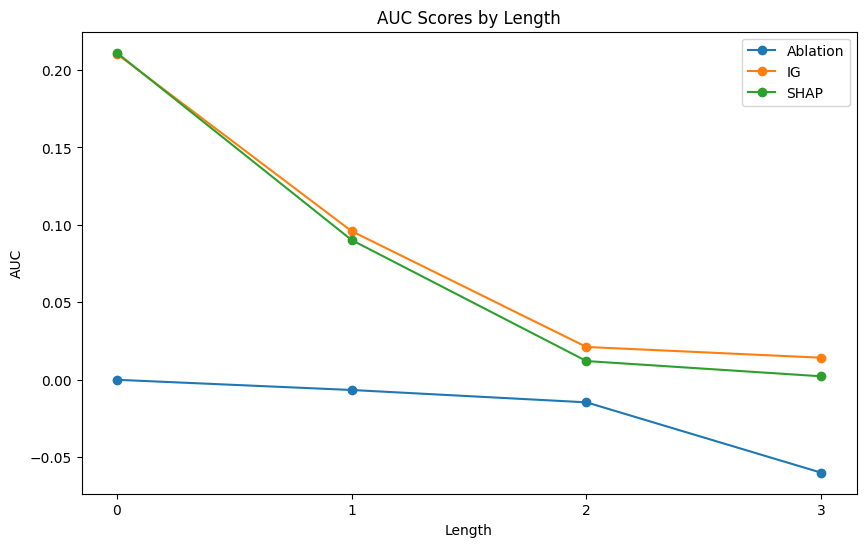

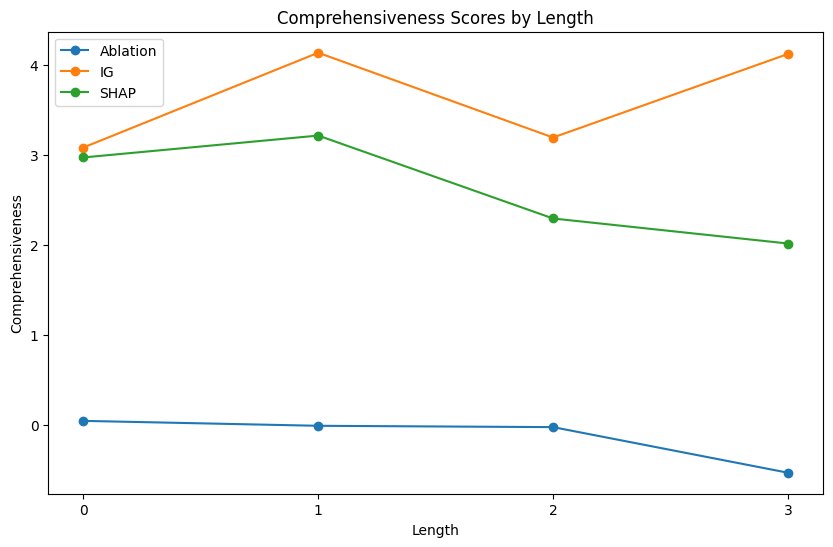

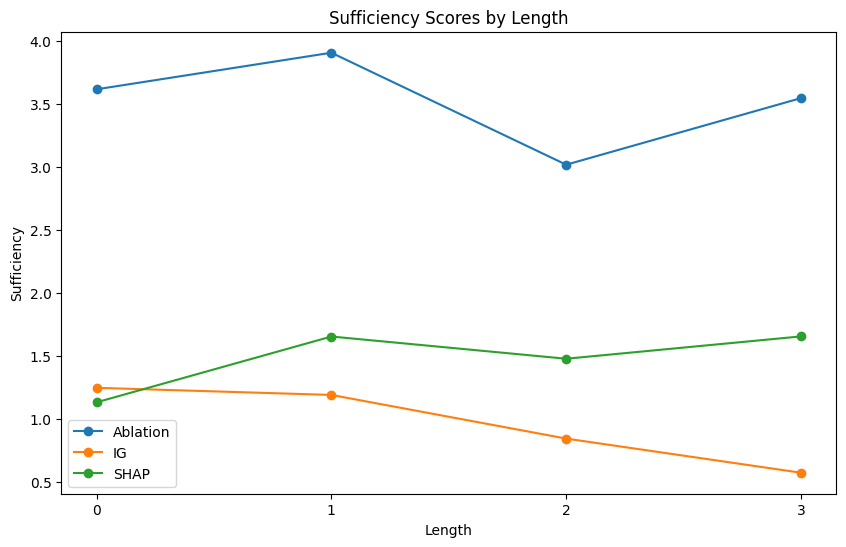

In [ ]:
import matplotlib.pyplot as plt

# Define the data from the tables
lengths = [0, 1, 2, 3]
methods = ['ablation', 'ig', 'shap']

# # Define the data for each method
# auc_ablation = [0.000857, -0.000652, -0.012419, -0.047500]
# auc_ig = [0.211571, 0.095394, 0.016535, -0.001000]
# auc_shap = [0.209143, 0.082636, 0.015302, 0.000750]

# comp_ablation = [0.379143, 0.166879, 0.154163, -0.207250]
# comp_ig = [2.934571, 3.467576, 3.046605, 3.337750]
# comp_shap = [2.764857, 2.970394, 1.926186, 2.580750]

# suff_ablation = [3.468571, 3.795894, 3.052465, 3.199750]
# suff_ig = [1.247000, 1.395667, 1.043953, 0.480750]
# suff_shap = [1.141143, 1.825061, 1.498605, 0.929750]

# # Define the data for each method
# auc_ablation = [0.003000, 0.001955, -0.011395, -0.045250]
# auc_ig = [0.211571, 0.096530, 0.019535, 0.004250]
# auc_shap = [0.208714, 0.076136, 0.011116, 0.003250]

# comp_ablation = [0.264143, 0.145758, 0.128395, -0.080000]
# comp_ig = [2.882857, 3.364833, 3.024535, 3.355500]
# comp_shap = [2.291857, 2.340015, 1.632953, 2.103750]

# suff_ablation = [3.755857, 3.764606, 2.878558, 3.179250]
# suff_ig = [1.297714, 1.444485, 0.853070, 0.472000]
# suff_shap = [1.725143, 2.119500, 2.110279, 1.655000]

# Define the data for each method
auc_ablation = [0.0, -0.006591, -0.014558, -0.060000]
auc_ig = [0.210429, 0.095970, 0.021186, 0.014250]
auc_shap = [0.211143, 0.090242, 0.012093, 0.002250]

comp_ablation = [0.045000, -0.009652, -0.024372, -0.531000]
comp_ig = [3.082000, 4.135091, 3.192930, 4.121250]
comp_shap = [2.971714, 3.214682, 2.293512, 2.015500]

suff_ablation = [3.617571, 3.908409, 3.018372, 3.547750]
suff_ig = [1.245143, 1.188485, 0.841488, 0.570250]
suff_shap = [1.129857, 1.652727, 1.476233, 1.653750]

# Plotting AUC
plt.figure(figsize=(10, 6))
plt.plot(lengths, auc_ablation, marker='o', label='Ablation')
plt.plot(lengths, auc_ig, marker='o', label='IG')
plt.plot(lengths, auc_shap, marker='o', label='SHAP')
plt.xlabel('Length')
plt.ylabel('AUC')
plt.title('AUC Scores by Length')
plt.legend()
plt.xticks(lengths)
plt.show()

# Plotting Comprehensiveness
plt.figure(figsize=(10, 6))
plt.plot(lengths, comp_ablation, marker='o', label='Ablation')
plt.plot(lengths, comp_ig, marker='o', label='IG')
plt.plot(lengths, comp_shap, marker='o', label='SHAP')
plt.xlabel('Length')
plt.ylabel('Comprehensiveness')
plt.title('Comprehensiveness Scores by Length')
plt.legend()
plt.xticks(lengths)
plt.show()

# Plotting Sufficiency
plt.figure(figsize=(10, 6))
plt.plot(lengths, suff_ablation, marker='o', label='Ablation')
plt.plot(lengths, suff_ig, marker='o', label='IG')
plt.plot(lengths, suff_shap, marker='o', label='SHAP')
plt.xlabel('Length')
plt.ylabel('Sufficiency')
plt.title('Sufficiency Scores by Length')
plt.legend()
plt.xticks(lengths)
plt.show()


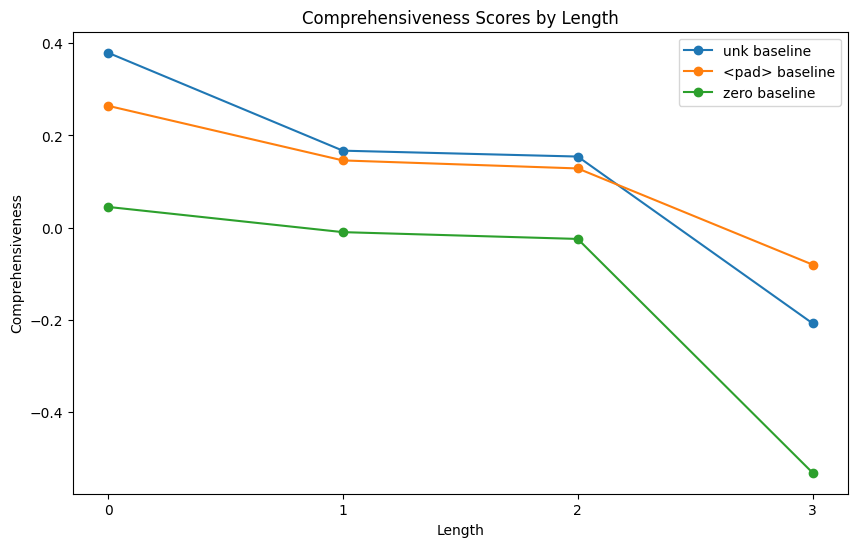

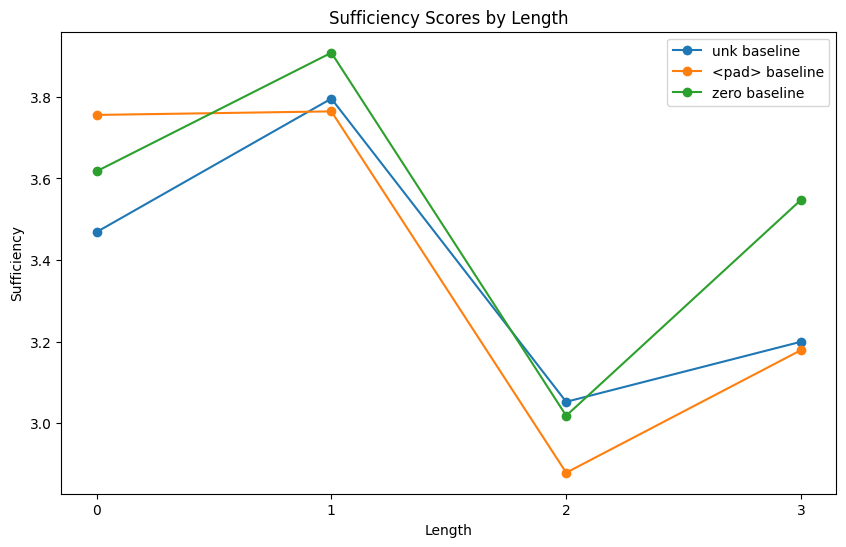

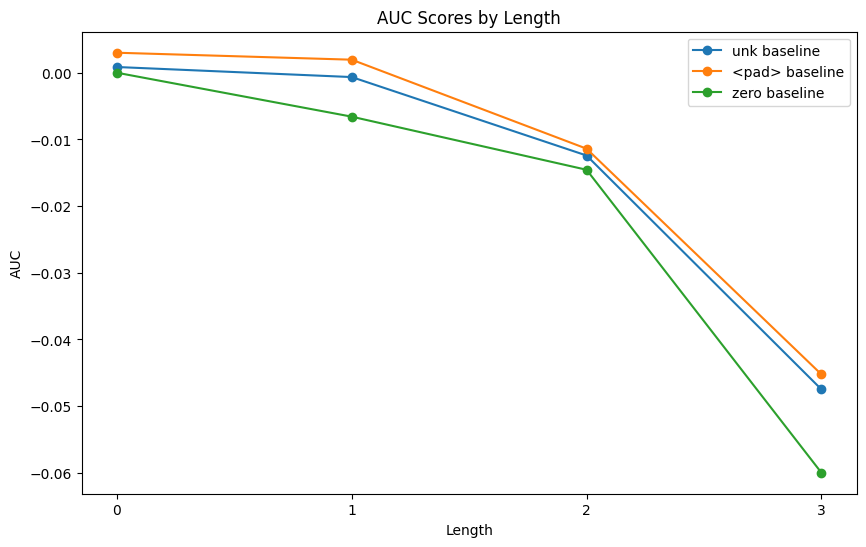

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the unk baseline
unk_comp = [0.379143, 0.166879, 0.154163, -0.207250]
unk_suff = [3.468571, 3.795894, 3.052465, 3.199750]
unk_auc = [0.000857, -0.000652, -0.012419, -0.047500]

# Data for the <pad> baseline
pad_comp = [0.264143, 0.145758, 0.128395, -0.080000]
pad_suff = [3.755857, 3.764606, 2.878558, 3.179250]
pad_auc = [0.003000, 0.001955, -0.011395, -0.045250]

# Data for the zero baseline
zero_comp = [0.045000, -0.009652, -0.024372, -0.531000]
zero_suff = [3.617571, 3.908409, 3.018372, 3.547750]
zero_auc = [0.000000, -0.006591, -0.014558, -0.060000]

# Lengths
lengths = np.arange(len(unk_comp))

# Plotting Comprehensiveness
plt.figure(figsize=(10, 6))
plt.plot(lengths, unk_comp, marker='o', label='unk baseline')
plt.plot(lengths, pad_comp, marker='o', label='<pad> baseline')
plt.plot(lengths, zero_comp, marker='o', label='zero baseline')
plt.xlabel('Length')
plt.ylabel('Comprehensiveness')
plt.title('Comprehensiveness Scores by Length')
plt.legend()
plt.xticks(lengths)
plt.show()

# Plotting Sufficiency
plt.figure(figsize=(10, 6))
plt.plot(lengths, unk_suff, marker='o', label='unk baseline')
plt.plot(lengths, pad_suff, marker='o', label='<pad> baseline')
plt.plot(lengths, zero_suff, marker='o', label='zero baseline')
plt.xlabel('Length')
plt.ylabel('Sufficiency')
plt.title('Sufficiency Scores by Length')
plt.legend()
plt.xticks(lengths)
plt.show()

# Plotting AUC
plt.figure(figsize=(10, 6))
plt.plot(lengths, unk_auc, marker='o', label='unk baseline')
plt.plot(lengths, pad_auc, marker='o', label='<pad> baseline')
plt.plot(lengths, zero_auc, marker='o', label='zero baseline')
plt.xlabel('Length')
plt.ylabel('AUC')
plt.title('AUC Scores by Length')
plt.legend()
plt.xticks(lengths)
plt.show()
